In [1]:
import datetime, time
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from functools import reduce
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql.types import (StructField, StringType,FloatType, 
                               DoubleType, IntegerType, StructType,
                              DateType)
from pyspark.sql import functions as F
from pyspark.sql import DataFrame as spDataFrame


from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (Binarizer, OneHotEncoder, StringIndexer, HashingTF, 
                                Tokenizer, StandardScaler, VectorAssembler,
                               OneHotEncoder, StringIndexer, VectorIndexer)
from pyspark.ml.classification import LogisticRegression, LinearSVC, LinearSVCModel
from pyspark.ml.evaluation import HasFeaturesCol
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import os
import matplotlib.pyplot as plt

from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import chi2, RFECV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

#from tokenizer import Tokenizer

/hpc/applications/anaconda/3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def unionAll(*dfs):
    return reduce(spDataFrame.unionAll, dfs)

This is to setup the sparksession. If additional resources need to be allocated it is done with this command

In [4]:

spark = SparkSession \
        .builder \
        .appName('Capstone Analysis') \
        .config("spark.driver.memory", "60g") \
        .config("spark.executor.memory", "60g") \
        .config("spark.executor.cores", "5") \
        .getOrCreate()

In [5]:
spark.version

'2.3.1'

In [6]:
spark.sparkContext.uiWebUrl

'http://b136.cm.cluster:4040'

## Import DATA

In [7]:
proc_data_schema = [StructField('time',IntegerType(),True),
                   StructField('user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('proc_name',StringType(),True),
                   StructField('strt',StringType())]
proc_final_struc = StructType(fields = proc_data_schema)
proc = spark.read.csv('../Dataset/proc.txt',schema=proc_final_struc)

auth_data_schema = [StructField('time',IntegerType(),True),
                   StructField('src_user@domain',StringType(),True),
                   StructField('dest_user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('dest_comp',StringType(),True),
                   StructField('auth_type',StringType(),True),
                   StructField('logon_type',StringType(),True),
                   StructField('auth_orient',StringType(),True),
                   StructField('success',StringType(),True)]
auth_final_struc = StructType(fields = auth_data_schema)
auth = spark.read.csv('../Dataset/auth.txt',schema=auth_final_struc )

flows_data_schema = [StructField('time',IntegerType(),False),
                   StructField('dur',IntegerType(),False),
                   StructField('src_comp',StringType(),False),
                   StructField('src_port',StringType(),False),
                   StructField('dest_comp',StringType(),False),
                   StructField('dest_port',StringType(),False),
                   StructField('protocol',StringType(),False),
                   StructField('pkt_cnt',IntegerType(),False),
                   StructField('byte_cnt',IntegerType(),False)]
flows_final_struc = StructType(fields = flows_data_schema)
flows = spark.read.csv('../Dataset/flows.txt',schema=flows_final_struc )

dns_data_schema = [StructField('time',IntegerType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('cmp_resolved',StringType(),True)]
dns_final_struc = StructType(fields = dns_data_schema)
dns = spark.read.csv('../Dataset/dns.txt',schema=dns_final_struc)

redteam_data_schema = [StructField('time',IntegerType(),True),
                   StructField('user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('dest_comp',StringType(),True)]
redteam_final_struc = StructType(fields = redteam_data_schema)
redteam = spark.read.csv('../Dataset/redteam.txt',schema=redteam_final_struc)

In [8]:
# dns.show(n=5,truncate=True)

This code is supposed to map the DNS connections into a network map

In [9]:
# dns_graph = new_df.toPandas()

In [10]:
# new_dns_graph = dns_graph.sample(5000)
# G = nx.from_pandas_edgelist(new_dns_graph, 'src_comp','cmp_resolved','count')

In [11]:
# from operator import itemgetter
# node_and_degree = G.degree()
# (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
# hub_ego = nx.ego_graph(G, largest_hub)
# # Draw graph
# pos = nx.spring_layout(hub_ego)


In [12]:
# nx.draw(G,pos,node_color='b', node_size=50, with_labels=False)
# nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], node_size=300, node_color='r')
# plt.show()

## Transform Data

This will be where we split all user@domain columns into user and domain columns

In [13]:
proc_split = F.split(proc['user@domain'],'@')
proc = proc.withColumn('src_user',proc_split.getItem(0))
proc = proc.withColumn('src_dmn',proc_split.getItem(1))
proc = proc.drop('user@domain')

proc = proc.withColumn('type',F.lit('Process'))

In [14]:
auth_src_split = F.split(auth['src_user@domain'],'@')
auth = auth.withColumn('src_user',auth_src_split.getItem(0))
auth = auth.withColumn('src_dmn',auth_src_split.getItem(1))

auth_dest_split = F.split(auth['dest_user@domain'],'@')
auth = auth.withColumn('dest_user',auth_dest_split.getItem(0))
auth = auth.withColumn('dest_dmn',auth_dest_split.getItem(1))

auth = auth.drop('src_user@domain','dest_user@domain')

auth = auth.withColumn('type',F.lit('Auth'))

In [15]:
redteam_split = F.split(redteam['user@domain'],'@')
redteam = redteam.withColumn('src_user',redteam_split.getItem(0))
redteam = redteam.withColumn('src_dmn',redteam_split.getItem(1))

redteam = redteam.drop('user@domain')

redteam = redteam.withColumn('type',F.lit('RedTeam'))

In [16]:

flows = flows.withColumn('avg_pkt_size', (flows['byte_cnt']/flows['pkt_cnt']).cast(DoubleType()))
flows = flows.na.drop(how='all')

flows = flows.withColumn('type',F.lit('DataFlow'))

# Test/Train split

In [17]:
split_days = 29
split_range = split_days * 3600 * 24

In [18]:
# #Split data into train/test segments. This will be done on the first number of days

# redteam = redteam.filter(redteam.time <= split_range)

# dns = dns.filter(dns.time <= split_range)

# proc = proc.filter(proc.time <= split_range)

# flows = flows.filter(flows.time <= split_range)

# auth = auth.filter(auth.time <= split_range)

In [19]:
days = 20
train_range = days * 3600 * 24

In [20]:
# #Split data into train/test segments. This will be done on the first number of days

# redteam_test = redteam.filter(redteam.time > train_range)
# redteam_train = redteam.filter(redteam.time <= train_range)

# dns_test = dns.filter(dns.time > train_range)
# dns_train = dns.filter(dns.time <= train_range)

# proc_test = proc.filter(proc.time > train_range)
# proc_train = proc.filter(proc.time <= train_range)

# flows_test = flows.filter(flows.time > train_range)
# flows_train = flows.filter(flows.time <= train_range)

# auth_test = auth.filter(auth.time > train_range)
# auth_train = auth.filter(auth.time <= train_range)

In [21]:
# colum = proc.columns
# colum.sort()

# proc = proc.select(colum)
# redteam = redteam.select(colum)
# auth = auth.select(colum)
# flows = flows.select(colum)

In [22]:
# master = unionAll(redteam,auth,proc,flows)

In [23]:
# print(master.count())

In [24]:
# master.select('strt').sort('strt').show()

This code was supposed to transform the time column from an int into a datetime data type

In [25]:
# redteam1 = redteam.select(F.to_date(redteam.time,'MM-dd HH:mm:ss').alias('date')).collect()
#redteam1 = redteam.rdd.map(lambda x: (x['time'], time.strftime('%m/%d %H:%M:%S', time.gmtime(x['time']) ))).toDF(['time','timestam'])

# DNS Data

In [26]:
# dns_train.show(5)

In [27]:
# F.pandas_udf()

In [28]:
def dns_extract(dns_dataset):
    dns_count = dns_dataset.groupby(dns_dataset.time,dns_dataset.src_comp).count().na.fill(0).sort('time')
    dns_count = dns_count.select(F.col('time'),F.col('src_comp'),F.col('count').alias('dns_count'))
    
    final_dns_dataset = dns_count
    
    temp_dns = first_dns_extract(dns_dataset)
    
    final_dns_dataset = final_dns_dataset.join(temp_dns,['time','src_comp'],'left')
    
    final_dns_dataset = final_dns_dataset.na.fill(0)
    
    final_dns_dataset = final_dns_dataset.sort(['time','src_comp'])
    
    return final_dns_dataset

In [29]:
def first_dns_extract(dns_dataset):
    newresolved = dns_dataset.groupby(dns_dataset.src_comp,dns_dataset.cmp_resolved).agg(F.min('time').alias('time')).sort('time')
    newresolved = newresolved.repartition(10).groupby(newresolved.time,newresolved.src_comp).count()
    newresolved = newresolved.repartition(10).select(F.col('time'),F.col('src_comp'),F.col('count').alias('newresolved_count')).sort('time')
    
    first_dns_dataset = newresolved
    return first_dns_dataset

In [30]:
# dns_sample = dns_extract(dns)

In [31]:
# start_time = time.time()
# pd_dns = dns_sample.toPandas()
# print("--- %s seconds ---" % (time.time() - start_time))

In [32]:
# start_time = time.time()

# dns_sample.count()



In [33]:
# print("--- %s seconds ---" % (time.time() - start_time))

# Proc Data

In [34]:
# proc_train.show(5)

In [35]:
# proc_train.select('strt').distinct().show()

In [36]:
# proc_subset = proc_train.filter((proc_train.time<2)&(proc_train.time>=0))

In [37]:
# proc_subset.show(10)

In [38]:
#proc_subset_test = proc_subset.groupby(proc_subset.time,proc_subset.src_comp,proc_subset.proc_name,proc_subset.strt).count()

In [39]:
# proc_subset_test.show(10)

In [40]:
# proc_subset_test = proc_subset.groupby(proc_subset.time,proc_subset.src_comp)\
#                     .agg(F.sum(F.when(proc_subset.strt=='Start',F.lit(1)).otherwise(F.lit(-1))).alias('LoggedOn'))\
#                     .withColumn('LoggedOn',F.greatest(F.lit(0),'LoggedOn'))\
#                     .sort('time','src_comp')


In [41]:
# proc_subset_test.show()

In [42]:
# proc_count = proc_train.groupby(proc_train.time,proc_train.src_comp).count().na.fill(0).sort('time')
# proc_count = proc_count.select(F.col('time'),F.col('src_comp'),F.col('count').alias('proc_total'))



In [43]:
# proc_count.show(10)

In [44]:
# proc_count.count()

In [45]:
# proc_exec = proc_train.filter(proc_train.strt=='Start').groupby(proc_train.time,proc_train.src_comp).count().na.fill(0).sort('time')
# proc_exec = proc_exec.select(F.col('time'),F.col('src_comp'),F.col('count').alias('proc_exec_total'))

In [46]:
# proc_exec.show(10)

In [47]:
# proc_exec.count()

In [48]:
# def first_proc_extract(proc_dataset):
#     newexecute = proc_dataset.filter(proc_dataset.strt=='Start').groupby(proc_dataset.src_comp,proc_dataset.proc_name).agg(F.min('time').alias('time')).sort('time')
#     newexecute = newexecute.groupby(newexecute.time,newexecute.src_comp).count()
#     newexecute = newexecute.select(F.col('time'),F.col('src_comp'),F.col('count').alias('newexecute_count')).sort('time')
    
#     first_execute_dataset = newexecute
#     return first_execute_dataset

In [49]:
# def proc_running_extract(proc_dataset):
#     proc_running = proc_dataset.groupby(proc_dataset.time,proc_dataset.src_comp)\
#                     .agg(F.sum(F.when(proc_dataset.strt=='Start',F.lit(1)).otherwise(F.lit(-1))).alias('Proc_run'))\
#                     .withColumn('Proc_run',F.greatest(F.lit(0),'Proc_run'))\
#                     .sort('time','src_comp')
#     return proc_running
    

In [50]:
# def proc_extract(proc_dataset):
#     proc_count = proc_dataset.groupby(proc_dataset.time,proc_dataset.src_comp).count().na.fill(0).sort('time')
#     proc_count = proc_count.select(F.col('time'),F.col('src_comp'),F.col('count').alias('proc_total'))
    
#     proc_exec = proc_dataset.filter(proc_dataset.strt=='Start').groupby(proc_dataset.time,proc_dataset.src_comp).count().na.fill(0).sort('time')
#     proc_exec = proc_exec.select(F.col('time'),F.col('src_comp'),F.col('count').alias('proc_exec_total'))
    
    
#     first_execute = first_proc_extract(proc_dataset)
    
#     proc_run = proc_running_extract(proc_dataset)
    
#     final_proc_dataset=proc_count
    
#     final_proc_dataset = final_proc_dataset.join(proc_exec,['time','src_comp'],'left')
    
#     final_proc_dataset = final_proc_dataset.join(first_execute,['time','src_comp'],'left')
    
#     final_proc_dataset = final_proc_dataset.join(proc_run,['time','src_comp'],'left')
    
#     final_proc_dataset = final_proc_dataset.na.fill(0)
    
#     final_proc_dataset = final_proc_dataset.sort(['time','src_comp'])
    
    
#     return final_proc_dataset

In [51]:
# proc_sample = proc_extract(proc)

In [52]:
# start_time = time.time()
# pd_proc = proc_sample.toPandas()
# print("--- %s seconds ---" % (time.time() - start_time))

In [53]:
# start_time = time.time()

# proc_sample.count()



In [54]:
# print("--- %s seconds ---" % (time.time() - start_time))

## Auth Data

In [55]:
# auth_train.show(20)

In [56]:
# failed_logon = auth_train.filter(auth_train.success=='Fail').groupby(auth_train.time,auth_train.src_comp).count().na.fill(0).sort('time')
# failed_logon = failed_logon.select(F.col('time'),F.col('src_comp'),F.col('count').alias('fail_count'))

In [57]:
# failed_logon.show(5)

In [58]:
# def auth_extract(auth_dataset):
#     failed_logon = auth_dataset.filter(auth_dataset.success=='Fail').groupby(auth_dataset.time,auth_dataset.src_comp).count().na.fill(0).sort('time')
#     failed_logon = failed_logon.select(F.col('time'),F.col('src_comp'),F.col('count').alias('fail_count'))
    
    
#     final_auth_dataset = failed_logon
#     return final_auth_dataset

In [59]:
# def auth_loggedon_extract(auth_dataset):
#     auth_loggedon = auth_dataset.filter((auth_dataset.success=="Success") & ((auth_dataset.auth_orient=='LogOn')|(auth_dataset.auth_orient=='LogOff'))).groupby(auth_dataset.time,auth_dataset.src_comp)\
#                     .agg(F.sum(F.when(auth_dataset.auth_orient=='LogOn',F.lit(1)).otherwise(F.lit(-1))).alias('LoggedOn'))\
#                     .withColumn('LoggedOn',F.greatest(F.lit(0),'LoggedOn'))\
#                     .sort('time','src_comp')
#     return auth_loggedon
    

In [60]:
# auth_sample = auth_loggedon_extract(auth_train)

In [61]:
# start_time = time.time()

# auth_sample.count()

In [62]:
# print("--- %s seconds ---" % (time.time() - start_time))

In [63]:
# auth_sample = auth_extract(auth_train)

In [64]:
# start_time = time.time()

# auth_sample.count()

In [65]:
# print("--- %s seconds ---" % (time.time() - start_time))

In [66]:
# def joined_auth_extract(auth_dataset):

#     failed_logon = auth_dataset.filter(auth_dataset.success=='Fail').groupby(auth_dataset.time,auth_dataset.src_comp).count().na.fill(0).sort('time')
#     failed_logon = failed_logon.select(F.col('time'),F.col('src_comp'),F.col('count').alias('fail_count'))
    
#     auth_loggedon = auth_loggedon_extract(auth_dataset)
    
#     final_auth_dataset = failed_logon.join(auth_loggedon,['time','src_comp'],'outer' )
#     return final_auth_dataset
    

In [67]:
# auth_sample = joined_auth_extract(auth_train)

In [68]:
# start_time = time.time()

# auth_sample.count()

In [69]:
# start_time = time.time()
# auth_sample = joined_auth_extract(auth)

In [70]:
# pd_auth = auth_sample.toPandas()
# print("--- %s seconds ---" % (time.time() - start_time))

In [71]:
# process_start = proc.groupby(proc.time).agg(F.when)
# process_start = process_start.a
# agg().sort('time')
# #process_start = process_start.select(F.col('time'),F.col('strt'),F.col('count').alias('proc_change'))

In [72]:
# auth_train.show(5)

# Redteam Data

In [73]:
# redteam_train.show(5)

In [74]:
# redteam_event = redteam_train.groupby(redteam_train.time, redteam_train.src_comp).count().na.fill(0).sort('time')
# redteam_event = redteam_event.select(F.col('time'),F.col('src_comp'),F.col('count').alias('redteam_event'))
# # redteam_event = redteam_event.withColumn('redteam_event',\
# #                                         F.when(redteam_event['redteam_event']>1,2).otherwise(redteam_event['redteam_event']))

In [75]:
# def redteam_extract(redteam_dataset):
#     redteam_event = redteam_dataset.groupby(redteam_dataset.time, redteam_dataset.src_comp).count().na.fill(0).sort('time')
#     redteam_event = redteam_event.select(F.col('time'),F.col('src_comp'),F.col('count').alias('redteam_event'))
    
#     final_redteam_dataset = redteam_event
#     return final_redteam_dataset

In [76]:
# start_time = time.time()
# redteam_sample = redteam_extract(redteam)
# redteam_sample.coalesce(1).write.csv('../Dataset/Output/total/redteam_output')
# print("--- %s seconds ---" % (time.time() - start_time))

In [77]:
# redteam_event.show(5)

# Flows Data

In [78]:
# flows_train.show(5)

In [79]:
# flows_data = flows_train.select('time','dur','src_comp','pkt_cnt','byte_cnt','avg_pkt_size')\
#                         .groupby('time','src_comp').agg(F.sum('dur').alias('dur'),F.sum('pkt_cnt').alias('pkt_cnt'),F.sum('byte_cnt').alias('byte_cnt'),F.avg('avg_pkt_size').alias('avg_pkt_size')).sort('time')

In [80]:
# flows_data.show(10)

In [81]:
# def flows_extract(flows_dataset):
#     flows_data = flows_dataset.select('time','dur','src_comp','pkt_cnt','byte_cnt','avg_pkt_size')\
#                         .groupby('time','src_comp').agg(F.sum('dur').alias('dur'),F.sum('pkt_cnt').alias('pkt_cnt'),F.sum('byte_cnt').alias('byte_cnt'),F.avg('avg_pkt_size').alias('avg_pkt_size')).sort('time')
    
#     final_flows_dataset = flows_data
#     return final_flows_dataset

In [82]:
# flows_sample = flows_extract(flows)

In [83]:
# start_time = time.time()

# # flows_sample.count()

In [84]:
# pd_flows = flows_sample.toPandas()
# print("--- %s seconds ---" % (time.time() - start_time))

# Import CSV Data

In [85]:
# proc_sample.columns

In [ ]:
start_time = time.time()
master_df = pd.read_csv('../Dataset/Output/complete_df.csv')
print("--- %s seconds ---" % (time.time() - start_time))

In [86]:
redteam_columns = ['time', 'src_comp', 'redteam_event']
auth_columns = ['time', 'src_comp', 'fail_count', 'LoggedOn']
dns_columns = ['time', 'src_comp', 'dns_count', 'newresolved_count']
proc_columns = ['time', 'src_comp', 'proc_total', 'proc_exec_total', 'newexecute_count', 'Proc_run']
flows_columns = ['time', 'src_comp', 'dur', 'pkt_cnt', 'byte_cnt', 'avg_pkt_size']

In [87]:
directory = "../Dataset/Output/total/"
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.csv'):
            filepath = root+'/'+file
            if "dns" in root:   
                pd_dns_df = pd.read_csv(filepath, names=dns_columns)
                print("imported ", filepath)
            elif "proc" in root:
                pd_proc_df = pd.read_csv(filepath, names=proc_columns)
                print("imported ", filepath)
            elif "flows" in root:   
                pd_flows_df = pd.read_csv(filepath, names=flows_columns)
                print("imported ", filepath)
            elif "redteam" in root:
                pd_redteam_df = pd.read_csv(filepath, names=redteam_columns)
                print("imported ", filepath)
            elif "auth" in root:
                pd_auth_df = pd.read_csv(filepath, names=auth_columns)
                print("imported ", filepath)
            else:
                print("Error importing ", file)

imported  ../Dataset/Output/total/dns_output_1.csv/part-00000-8e978295-68d5-4fc4-bcc1-6dad503ac18f-c000.csv
imported  ../Dataset/Output/total/auth_output_1.csv/part-00000-9300e0d1-109c-4aa9-b94b-1c85fb226b79-c000.csv
imported  ../Dataset/Output/total/flows_output_1.csv/part-00000-383ab297-32a7-44c5-9652-f244032fc7c5-c000.csv
imported  ../Dataset/Output/total/proc_output_1/part-00000-cb837398-0945-4ee1-bf0e-a253fe2e3e50-c000.csv
imported  ../Dataset/Output/total/redteam_output/part-00000-9af1a1bd-ec59-4454-bc6d-3203ebe27fbf-c000.csv


In [88]:
split_days = 3
split_range = split_days * 3600 * 24

In [89]:
#Split data into train/test segments. This will be done on the first number of days

redteam = pd_redteam_df[pd_redteam_df.time <= split_range]

dns = pd_dns_df[pd_dns_df.time <= split_range]

proc = pd_proc_df[pd_proc_df.time <= split_range]

flows = pd_flows_df[pd_flows_df.time <= split_range]

auth = pd_auth_df[pd_auth_df.time <= split_range]

In [90]:
# days = 2
# train_range = days * 3600 * 24

In [91]:
# #Split data into train/test segments. This will be done on the first number of days

# redteam_test = redteam[redteam.time > train_range]
# redteam_train = redteam[redteam.time <= train_range]

# dns_test = dns[dns.time > train_range]
# dns_train = dns[dns.time <= train_range]

# proc_test = proc[proc.time > train_range]
# proc_train = proc[proc.time <= train_range]

# flows_test = flows[flows.time > train_range]
# flows_train = flows[flows.time <= train_range]

# auth_test = auth[auth.time > train_range]
# auth_train = auth[auth.time <= train_range]

In [92]:
master_df = dns.merge(auth,on=['time','src_comp'],how='outer')
master_df = master_df.merge(flows,on=['time','src_comp'],how='outer')
master_df = master_df.merge(redteam,on=['time','src_comp'],how='outer')
master_df = master_df.merge(proc,on=['time','src_comp'],how='outer')

In [93]:
master_df=master_df.fillna(0)

In [94]:
master_df.head(5)

,time,src_comp,dns_count,newresolved_count,fail_count,LoggedOn,dur,pkt_cnt,byte_cnt,avg_pkt_size,redteam_event,proc_total,proc_exec_total,newexecute_count,Proc_run
0,2,C4653,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,C5782,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,C1191,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,C3380,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,C2436,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
y = master_df.redteam_event
X = master_df[master_df.columns.difference(['redteam_event','src_comp','time'])]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33,stratify=y )

In [98]:
classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

In [99]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[13892747        0]
 [       8        0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


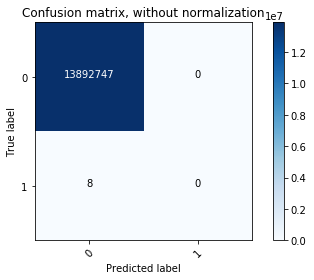

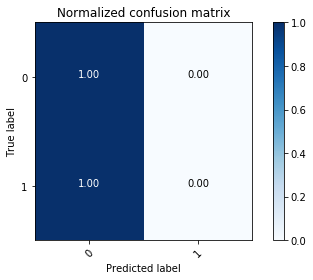

In [106]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = ['0','1']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()

In [18]:
skf = StratifiedKFold(y, n_folds=2)
print(skf)

sklearn.cross_validation.StratifiedKFold(labels=[ 0.  0.  0. ...,  0.  0.  0.], n_folds=2, shuffle=False, random_state=None)


In [ ]:
for train_index, test_index in skf.split(X, y):
    

# Combine Data

In [73]:
# stringIndexer = StringIndexer(inputCol='dest_comp', outputCol='successType')
# model = stringIndexer.fit(redteam)
# indexed = model.transform(redteam)

# encoder = OneHotEncoder(inputCol='successType', outputCol='successVec')
# encoded = encoder.transform(indexed)
# encoded.show()



This section I tried transforming the dataframes into pandas dataframes. This works, sort of, but it is very slow.

In [74]:
# redteam_pd_train = redteam_train.toPandas()
# redteam_pd_train['time'] = pd.to_datetime(redteam_pd_train['time'],unit='s')

In [75]:
# # failed_logon_pd_train = failed_logon.toPandas()

# # failed_user_logon_pd_train = failed_user_logon.toPandas()

# failed_user_logon_pd_train['time'] = pd.to_datetime(failed_user_logon_pd_train['time'],unit='s')

# failed_user_logon_pd_train_resamp = failed_user_logon_pd_train.groupby('src_user').apply(lambda x: x.set_index('time').resample('1Min').sum()).reset_index()

# redteam_pd_user_train = redteam_pd_train.groupby('src_user').apply(lambda x: x.set_index('time').resample('1Min').sum()).reset_index()

# combined_file = pd.merge(redteam_pd_train, failed_logon_pd_train, on=['time','src_comp'], how='outer')

# inner_join = pd.merge(redteam_pd_train, failed_logon_pd_train, on=['time','src_comp'], how='inner')

# inner_join.shape

# inner_user_join = pd.merge(redteam_pd_train, failed_user_logon_pd_train, on=['time','src_user'], how='inner')

# inner_user_join.shape

# failed_logon_pd_train.shape

# redteam_pd_train.shape

In [ ]:
def time_subset(dataset, bat_size, n, start_time ):
    return dataset.filter((dataset.time<((bat_size*(n+1))+start_time)) & (dataset.time>=(bat_size*n+start_time)))

In [ ]:
def dataset_extractor(redteam_dataset, authentication_dataset, flows_dataset, process_dataset, 
                     dns_dataset, iterations = 576, complete = False ,batch_size = 300 ):  
    start_time = authentication_dataset.agg({"time":"min"}).collect()[0]["min(time)"]
    total_time = authentication_dataset.agg({"time":"max"}).collect()[0]["max(time)"]
    
    if complete:
        batches = int(total_time/batch_size)
    else: 
        batches = iterations
    switch = 0
    
    
    flows_data = flows_extract(flows_dataset)
    
    dns_data = dns_extract(dns_dataset)

    proc_data = proc_extract(process_dataset)
    
    proc_running_data = proc_running_extract(process_dataset)
    
    auth_data = auth_extract(authentication_dataset)
    
    auth_loggedon = auth_loggedon_extract(authentication_dataset)
    
    redteam_data = redteam_extract(redteam_dataset)
    print("Data Extraction Complete")
    
    for i in range(batches):
        #Here we are breaking the data up into seperate segments
        
        subset_logon = time_subset(auth_data, batch_size, i, start_time)

        subset_flows_data = time_subset(flows_data, batch_size, i, start_time)
        
#         subset_first_proc_data = time_subset(first_proc_data, batch_size, i, start_time)
        subset_proc_data = time_subset(proc_data, batch_size, i, start_time)
        subset_proc_running_data = time_subset(proc_running_data, batch_size, i, start_time)
        subset_auth_loggedon_data = time_subset(auth_loggedon, batch_size, i, start_time)
        
        subset_dns_data_data = time_subset(dns_data, batch_size, i, start_time)
#         subset_first_dns_data = time_subset(first_dns_data, batch_size, i, start_time)
        
        subset_redteam = time_subset(redteam_data, batch_size, i, start_time)
        

        #Here we join the data
        temp_subset = subset_redteam.join(subset_logon,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_flows_data,['time','src_comp'],'outer')
#         temp_subset = temp_subset.join(subset_first_proc_data,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_proc_data,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_proc_running_data,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_auth_loggedon_data,['time','src_comp'],'outer')
        temp_subset = temp_subset.join(subset_dns_data_data,['time','src_comp'],'outer')
#         temp_subset = temp_subset.join(subset_first_dns_data,['time','src_comp'],'outer')
        
        
        temp_subset = temp_subset.na.fill(0)

        temp_subset = temp_subset.groupby('src_comp').agg(F.min('time').alias('time')\
                                                         ,F.sum('redteam_event').alias('redteam_event')\
                                                         ,F.sum('dur').alias('dur')\
                                                         ,F.sum('fail_count').alias('fail_count')\
                                                         ,F.sum('dns_count').alias('dns_count')\
                                                         ,F.sum('newresolved_count').alias('newresolved_count')\
                                                         ,F.sum('proc_total').alias('proc_total')\
                                                         ,F.sum('Proc_run').alias('Proc_run')\
                                                         ,F.sum('LoggedOn').alias('LoggedOn')\
                                                         ,F.sum('proc_exec_total').alias('proc_exec_total')\
                                                         ,F.sum('newexecute_count').alias('newexecute_count')\
                                                         ,F.sum('pkt_cnt').alias('pkt_cnt')\
                                                         ,F.sum('byte_cnt').alias('byte_cnt')\
                                                         ,F.avg('avg_pkt_size').alias('avg_pkt_size'))\
                                                    .sort('time','src_comp')

        temp_subset = temp_subset.withColumn('redteam_event',\
                                            F.when(temp_subset['redteam_event']>1,2).otherwise(temp_subset['redteam_event']))

        if switch == 0:
            master_subset = temp_subset
            switch = 1
        else:
            master_subset = master_subset.union(temp_subset)
    
    return master_subset


In [ ]:
# def dataset_extractor(redteam_dataset, authentication_dataset, flows_dataset, process_dataset, 
#                      dns_dataset, iterations = 576, complete = False ,batch_size = 300 ):  
#     start_time = authentication_dataset.agg({"time":"min"}).collect()[0]["min(time)"]
#     total_time = authentication_dataset.agg({"time":"max"}).collect()[0]["max(time)"]
    
#     if complete:
#         batches = int(total_time/batch_size)
#     else: 
#         batches = iterations
#     switch = 0
    
    
#     flows_data = flows_extract(flows_dataset)
    
#     dns_data = dns_extract(dns_dataset)

#     proc_data = proc_extract(process_dataset)
    
#     proc_running_data = proc_running_extract(process_dataset)
    
# #     auth_data = auth_extract(authentication_dataset)
    
# #     auth_loggedon = auth_loggedon_extract(authentication_dataset)
    
#     redteam_data = redteam_extract(redteam_dataset)
#     print("Data Extraction Complete")
    
#     for i in range(batches):
#         #Here we are breaking the data up into seperate segments
        
# #         subset_logon = time_subset(auth_data, batch_size, i, start_time)

#         subset_flows_data = time_subset(flows_data, batch_size, i, start_time)
        
# #         subset_first_proc_data = time_subset(first_proc_data, batch_size, i, start_time)
#         subset_proc_data = time_subset(proc_data, batch_size, i, start_time)
#         subset_proc_running_data = time_subset(proc_running_data, batch_size, i, start_time)
# #         subset_auth_loggedon_data = time_subset(auth_loggedon, batch_size, i, start_time)
        
#         subset_dns_data_data = time_subset(dns_data, batch_size, i, start_time)
# #         subset_first_dns_data = time_subset(first_dns_data, batch_size, i, start_time)
        
#         subset_redteam = time_subset(redteam_data, batch_size, i, start_time)
        

#         #Here we join the data
#         temp_subset = subset_redteam.join(subset_flows_data,['time','src_comp'],'outer')
# #         temp_subset = temp_subset.join(subset_flows_data,['time','src_comp'],'outer')
# #         temp_subset = temp_subset.join(subset_first_proc_data,['time','src_comp'],'outer')
#         temp_subset = temp_subset.join(subset_proc_data,['time','src_comp'],'outer')
#         temp_subset = temp_subset.join(subset_proc_running_data,['time','src_comp'],'outer')
# #         temp_subset = temp_subset.join(subset_auth_loggedon_data,['time','src_comp'],'outer')
#         temp_subset = temp_subset.join(subset_dns_data_data,['time','src_comp'],'outer')
# #         temp_subset = temp_subset.join(subset_first_dns_data,['time','src_comp'],'outer')
        
        
#         temp_subset = temp_subset.na.fill(0)

#         temp_subset = temp_subset.groupby('src_comp').agg(F.min('time').alias('time')\
#                                                          ,F.sum('redteam_event').alias('redteam_event')\
#                                                          ,F.sum('dur').alias('dur')\
#                                                          ,F.sum('dns_count').alias('dns_count')\
#                                                          ,F.sum('newresolved_count').alias('newresolved_count')\
#                                                          ,F.sum('proc_total').alias('proc_total')\
#                                                          ,F.sum('Proc_run').alias('Proc_run')\
#                                                          ,F.sum('proc_exec_total').alias('proc_exec_total')\
#                                                          ,F.sum('newexecute_count').alias('newexecute_count')\
#                                                          ,F.sum('pkt_cnt').alias('pkt_cnt')\
#                                                          ,F.sum('byte_cnt').alias('byte_cnt')\
#                                                          ,F.avg('avg_pkt_size').alias('avg_pkt_size'))\
#                                                     .sort('time','src_comp')

#         temp_subset = temp_subset.withColumn('redteam_event',\
#                                             F.when(temp_subset['redteam_event']>1,2).otherwise(temp_subset['redteam_event']))

#         if switch == 0:
#             master_subset = temp_subset
#             switch = 1
#         else:
#             master_subset = master_subset.union(temp_subset)
    
#     return master_subset


In [ ]:
start_time = time.time()

In [ ]:
master_subset = dataset_extractor(redteam_train, auth_train, flows_train, proc_train, dns_train)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
master_subset.coalesce(1).write.csv('../Dataset/Output/final_output.csv')

In [77]:
# master_subset.columns

['src_comp',
 'time',
 'redteam_event',
 'dur',
 'fail_count',
 'dns_count',
 'newresolved_count',
 'proc_total',
 'Proc_run',
 'LoggedOn',
 'proc_exec_total',
 'newexecute_count',
 'pkt_cnt',
 'byte_cnt',
 'avg_pkt_size']

In [78]:
test_master_subset = dataset_extractor(redteam_test, auth_test, flows_test, proc_test, dns_test, 288)

Data Extraction Complete


In [ ]:
master_subset.count()

In [ ]:
# master_subset.show()

# Model creation

In [ ]:
# label = master_subset.select('redteam_event').alias('label')
# feature_labels = [c for c in master_subset.columns if c not in {'time','src_comp','redteam_event'}]
# features = master_subset.select([c for c in master_subset.columns if c not in {'time','src_comp','redteam_event'}])


In [82]:
feature_labels = [c for c in master_subset.columns if c not in {'time','src_comp','redteam_event'}]
# features = master_subset.select([c for c in master_subset.columns if c not in {'time','src_comp','redteam_event'}])
assembler = VectorAssembler(inputCols=feature_labels, outputCol="features")

In [ ]:
# vecAssembler = VectorAssembler(inputCols=feature_labels, outputCol="features")
# features = vecAssembler.transform(features).head().features


In [ ]:
# features.show(5)

In [ ]:
# tester = label.withColumn('features',features)

In [ ]:
# X.show()

In [ ]:
# tester = master_subset.select('redteam_event','dur', 'fail_count', 'pkt_cnt', 'byte_cnt', 'avg_pkt_size')

In [ ]:
# # Create a LogisticRegression instance. This instance is an Estimator.
# lr = LogisticRegression(maxIter=10, regParam=0.01)
# # Print out the parameters, documentation, and any default values.
# print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")

In [ ]:
# model1 = lr.fit(tester)

# # Since model1 is a Model (i.e., a transformer produced by an Estimator),
# # we can view the parameters it used during fit().
# # This prints the parameter (name: value) pairs, where names are unique IDs for this
# # LogisticRegression instance.
# print("Model 1 was fit using parameters: ")
# print(model1.extractParamMap())

# # We may alternatively specify parameters using a Python dictionary as a paramMap
# paramMap = {lr.maxIter: 20}
# paramMap[lr.maxIter] = 30  # Specify 1 Param, overwriting the original maxIter.
# paramMap.update({lr.regParam: 0.1, lr.threshold: 0.55})  # Specify multiple Params.

# # You can combine paramMaps, which are python dictionaries.
# paramMap2 = {lr.probabilityCol: "myProbability"}  # Change output column name
# paramMapCombined = paramMap.copy()
# paramMapCombined.update(paramMap2)

# # Now learn a new model using the paramMapCombined parameters.
# # paramMapCombined overrides all parameters set earlier via lr.set* methods.
# model2 = lr.fit(training, paramMapCombined)
# print("Model 2 was fit using parameters: ")
# print(model2.extractParamMap())

In [83]:
log_reg_redteam = LogisticRegression(featuresCol = 'features', labelCol='redteam_event')

In [84]:
pipeline = Pipeline(stages = [assembler,log_reg_redteam])

In [ ]:
fit_model = pipeline.fit(master_subset)

## Data Analysis

In [ ]:
# proc_domains = proc.select('domain').distinct()
# proc_users = proc.select('user').distinct()

In [ ]:
# proc_domains.coalesce(1).write.csv('domains.csv')
# proc_users.coalesce(1).write.csv('users.csv')

In [ ]:
# proc.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in proc.columns)).show()

In [ ]:
# flows.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in flows.columns)).show()

In [ ]:
auth.select('success').distinct().show()

In [ ]:
auth.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in auth.columns)).show()

In [ ]:
flows.orderBy("avg_pkt_size").show()

In [ ]:
flows.select([count(when(isnan(c)|col(c).isNull(), c)).alias(c) for c in flows.columns]).show()

In [ ]:
dns.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in dns.columns)).show()

In [ ]:
proc.show()

In [ ]:
redteam.printSchema()

In [ ]:
from pyspark.sql.functions import lit, unix_timestamp
start = datetime.date(2018,1,1)
#datetime.timestamp(2018,1,1,12,0,0)



In [ ]:
datetime.datetime.fromtimestamp(time.mktime(start.timetuple()) + 228150)

In [ ]:
func = udf (lambda x: datetime.datetime.fromtimestamp(time.mktime(start.timetuple()) + x).date(),DateType() )

In [ ]:
redteam1 = redteam.withColumn("timestam", redteam.select("time")),'yyyy-MM-dd HH:mm:ss').cast("timestamp") )

In [ ]:
import time

time_update = udf(lambda x: time.strftime('%m/%d %H:%M:%S', time.gmtime(x)))

#timestam = time.strftime('%m/%d %H:%M:%S', time.gmtime(redteam.select("time")))

# Create Classification model

In [ ]:
X = 
y = 

In [ ]:
cv = StratifiedKFold(n_splits=6)
classifier = xgb.XGBClassifier()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    print('round ',i+1)
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Classify Test Data

In [107]:
test_flows_data = flows_extract(flows_train)

test_dns_data = dns_extract(dns_train)

test_proc_data = proc_extract(proc_train)

test_proc_running_data = proc_running_extract(proc_train)

test_auth_data = auth_extract(auth_train)

test_auth_loggedon = auth_loggedon_extract(auth_train)

test_redteam_data = redteam_extract(redteam_train)

In [108]:
test_flows_data.columns

['time', 'src_comp', 'dur', 'pkt_cnt', 'byte_cnt', 'avg_pkt_size']

In [109]:
test_dns_data.columns

['time', 'src_comp', 'dns_count', 'newresolved_count']

In [110]:
test_proc_data.columns

['time', 'src_comp', 'proc_total', 'proc_exec_total', 'newexecute_count']

In [111]:
test_proc_running_data.columns

['time', 'src_comp', 'Proc_run']

In [112]:
test_auth_data.columns

['time', 'src_comp', 'fail_count']

In [113]:
test_auth_loggedon.columns

['time', 'src_comp', 'LoggedOn']

# Interpret Features